In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal
from utils import audio, channels

cwd = os.getcwd()

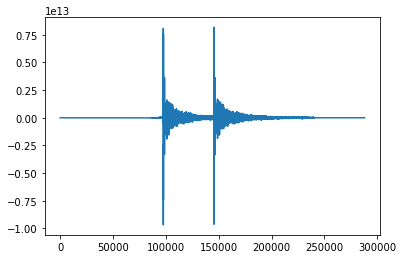

In [2]:
# Sync with chirp through octagon
chirp_duration = 1
fs = 48000
double_chirp = True

sample_times = np.linspace(0, chirp_duration, fs * chirp_duration)
chirp = scipy.signal.chirp(sample_times, 20, chirp_duration, 10000)
reverse_chirp = chirp[::-1]

if double_chirp:
    received_signal, samplerate = audio.wav_to_signal("double_chirp_octagon", os.path.join(cwd, "audio_files"))
else:
    received_signal, samplerate = audio.wav_to_signal("single_chirp_octagon", os.path.join(cwd, "audio_files"))

convolved = np.convolve(received_signal, reverse_chirp)

plt.plot(convolved)
plt.show(block=False)



Start recording for 10 seconds...
Finish recording


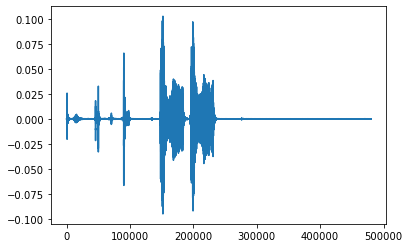

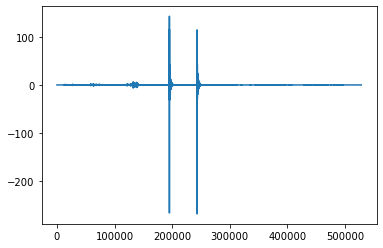

In [5]:
# Sync with real channel
chirp_duration = 1
record_duration = 10
fs = 48000
double_chirp = True

received_signal = audio.record(record_duration, fs)

sample_times = np.linspace(0, chirp_duration, fs * chirp_duration)
chirp = scipy.signal.chirp(sample_times, 20, chirp_duration, 10000)
reverse_chirp = chirp[::-1]

convolved = np.convolve(received_signal, reverse_chirp)

plt.plot(convolved)
plt.show(block=False)